In [10]:
import numpy as np
import matplotlib.pyplot as plt 

def load_dataset(file_path):
    """Load dataset from the file path given, convert the data into ndarray"""
    dataset = np.loadtxt(file_path, dtype=float, delimiter='\t')
    return dataset

def calc_euclidean_dist(arr1, arr2):
    """Calculate the Euclidean distance between two arrays and return a float number."""
    dist_sq = ((arr1 - arr2) ** 2).sum()
    return np.sqrt(dist_sq)

def random_centroids(dataset, k):
    """Generate k centroids randomly given a dateset.
    
    Args:   
        dataset: ndarray of inputs. Shape (m, n)
        k: number of centriods 
    Return:
        centriods: ndarray of centroids. Shape (k, n)
    """
    m, n = dataset.shape
    centroids = np.zeros((k, n))

    for j in range(n):
        min_j = min(dataset[:, j])
        range_j = max(dataset[:, j]) - min_j
        centroids[:, j] = min_j + range_j * np.random.rand(k)
    
    return centroids

def k_means(dataset, k, dist_calc=calc_euclidean_dist, generate_centroids=random_centroids):
    """Perform K means clustering for a given dataset.
    
    Args:
        dataset: ndarray of inputs. Shape (m, n)
        k: number of centriods 
        dist_calc: calculate the distance between examples. Default calculation: Euclidean distance
        generate_centroids: initialize centroids for clustring. Default: randomly generate centroids
    Returns:
        centroids: ndarray of centroids. Shape (k, n)
        clusters: clustered dataset of shape (m, 2), 1st col as closest centroid & 2nd col as sqaured dist to centroid
    """
    m, n = dataset.shape
    clusters = np.zeros((m, 2))
    centroids = generate_centroids(dataset, k)
    centroids_changed = True

    while centroids_changed:
        centroids_changed = False
        # calculate dist between data and centroids
        for i in range(m):
            min_dist = float('inf')
            min_j = -1

            for j in range(k):
                dist = dist_calc(centroids[j], dataset[i])
                if dist < min_dist:
                    min_dist = dist
                    min_j = j
            
            if clusters[i, 0] != min_j:
                centroids_changed = True
            
            clusters[i, :] = min_j, min_dist ** 2   # col2 stores the squared dist to cluster

        # calculate cluster mean and update centroids
        for i in range(k):
            centroids[i, :] = dataset[clusters[:, 0] == i, :].mean(axis=0)
            
    return centroids, clusters

def plot_clusters(dataset, clusters, k, save_path):
    """Plot the clustered dataset"""
    fig, ax = plt.subplots()
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    
    for i in range(k):
        ax.scatter(dataset[clusters[:, 0] == i, 0], dataset[clusters[:, 0] == i, 1], c=colors[i]) 
    
    fig.savefig(save_path)

def bisect_kmeans(dataset, k, dist_calc=calc_euclidean_dist):
    """Bisecting K Means Clustering
    
    Args:
        dataset: ndarray of inputs. Shape (m, n)
        k: number of centriods 
        dist_calc: calculate the distance between examples. Default calculation: Euclidean distance
    Returns:
        centroids: ndarray of centroids. Shape (k, n)
        clusters: clustered dataset of shape (m, 2), 1st col as closest centroid & 2nd col as sqaured dist to centroid
    """
    m, n = dataset.shape
    centroids = np.zeros((k, n))
    centroids[0] = dataset.mean(axis=0)     # initialze the first centroid

    clusters = np.zeros((m, 2))     # initialize all data to one cluster
    for i in range(m):
        clusters[i, 1] = dist_calc(centroids[0], dataset[i]) ** 2
    
    num = 1     # current number of centroids
    while num < k:
        min_rss = float('inf')

        for i in range(num):
            # obtain the data points in cluster_i and split it into two new clusters
            data_i = dataset[clusters[:, 0] == i]
            centroids_split, cluster_split = k_means(data_i, 2)

            rss_split = cluster_split[:, 1].sum()       # rss of two new clusters after split
            rss_not_split = clusters[clusters[:, 0] != i, 1].sum()      # the rss of unsplitted clusters

            if rss_not_split + rss_split < min_rss:
                min_rss = rss_not_split + rss_split
                best_cent_to_split = i
                new_centroids = centroids_split.copy()
                new_clusters = cluster_split.copy()
        
        # update centroids
        centroids[i] = new_centroids[0]
        centroids[num] = new_centroids[1]

        # assign the splitted clusters to be cluster_i and the cluster_num
        # update clusters
        new_clusters[new_clusters[:, 0] == 1, 0] = num
        new_clusters[new_clusters[:, 0] == 0, 0] = best_cent_to_split
        # the new_clusters update can only be in this way!!!
        # 0 == best_cent_to_split & 1 == num, then if bcts == 1, then all data will be cluster num
        # 0 == num & 1 == best_cent_to_split, then in iteration 1 num is 1, all data will be clustet 0
        
        clusters[clusters[:, 0] == best_cent_to_split, :] = new_clusters
        
        num += 1

    return centroids, clusters

In [49]:
dat = load_dataset('testSet.txt')
a0 = min(dat[:, 0])
b0 = max(dat[:, 0])
a1 = min(dat[:, 1])
b1 = max(dat[:, 1])
print(a0, b0, a1, b1)

-5.379713 4.838138 -4.232586 5.1904


In [28]:
centroids, clusters = k_means(dat, 4)

In [29]:
centroids

array([[ 2.6265299 ,  3.10868015],
       [ 2.80293085, -2.7315146 ],
       [-2.46154315,  2.78737555],
       [-3.38237045, -2.9473363 ]])

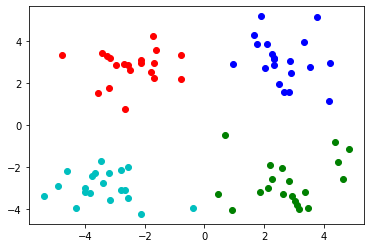

In [51]:
# fig, ax = plt.subplots()
# ax.scatter(dat[clusters[:, 0] == 0, 0], dat[clusters[:, 0] == 0, 1], color=1)
# ax.scatter(dat[clusters[:, 0] == 1, 0], dat[clusters[:, 0] == 1, 1], c='green')
# ax.scatter(dat[clusters[:, 0] == 2, 0], dat[clusters[:, 0] == 2, 1], c='blue')
# ax.scatter(dat[clusters[:, 0] == 3, 0], dat[clusters[:, 0] == 3, 1], c='yellow')

plot_clusters(dat, clusters, 4, 'test_cluster.png')

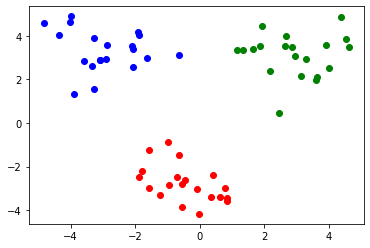

In [142]:
dat2 = load_dataset('testSet2.txt')
cent, clust = bisect_kmeans(dat2, 3)
plot_clusters(dat2, clust, 3, 'test_bisect.png')

In [81]:
import geocoder
from time import sleep
import my_constants as API_KEY
import math


def place_finder(file_name, save_file):
    """Find the latidude and longitude of places on the input file.
    
    Args:
        file_name: the file containing all places to be found
        save_file: txt file contains original info and latitude & longitude info
    Returns:
        geo_mat: ndarray containing latitude and longitude info of all locations
    """
    fw = open(save_file, 'w')
    ll_coords = []

    for line in open(file_name, 'r').readlines():
        line = line.strip()
        strs = line.split('\t')
        addr = strs[1] + ', ' + strs[2]
        
        try:
            g = geocoder.bing(addr, key=API_KEY.bing_api_key)
            ll_coord = g.latlng
        except:
            print('error fetching')
        
        fw.write('{}\t{}\t{}\n'.format(line, ll_coord[0], ll_coord[1]))
        ll_coords.append(ll_coord)
        sleep(1)
    
    fw.close()    
    return np.array(ll_coords)

def distance_SLC(p1, p2):
    """Compute the distance between p1 and p2 using the spherical law of consines.
    
    Args:
        p1: array of [lat, lng] of place1
        p2: array of [lat, lng] of place1
    Return:
        float number as the distance between two locations
    """
    lat1 = p1[0] * math.pi / 180
    lat2 = p2[0] * math.pi / 180
    lng1 = p1[1] * math.pi / 180
    lng2 = p2[1] * math.pi / 180

    cos = math.cos(lat2) * math.cos(lat1) * math.cos(lng2 - lng1) + math.sin(lat1) * math.sin(lat2)
    
    return math.acos(cos) * 6371.0


def club_clusters(file_name, save_file, save_img, k=5):
    """Cluster locations using Bisecting Kmeans with LSC distance and plot them on map.
    
    Args:
        file_name: the file containing all places to be found
        save_file: txt file contains original info and latitude & longitude info
        save_img: path to save image 
        k: number of clusters. Default: 5    
    """
    ll_coords = place_finder(file_name, save_file)
    centroids, clusters = bisect_kmeans(ll_coords, k, dist_calc=distance_SLC)

    fig = plt.figure()
    coords_limit = [0.1, 0.1, 0.8, 0.8]
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    axprops = dict(xticks=[], yticks=[])

    ax0 = fig.add_axes(coords_limit, label='ax0', **axprops)
    map_img = plt.imread('Portland.png')
    ax0.imshow(map_img)

    ax1 = fig.add_axes(coords_limit, label='ax1', frameon=False)
    for i in range(k):
        ax1.scatter(ll_coords[clusters[:, 0] == i, 1], ll_coords[clusters[:, 0] == i, 0], c=colors[i])
    
    ax1.scatter(centroids[:, 1], centroids[:, 0], marker='+', s=200)
    plt.xlabel('longtitude')
    plt.ylabel('latitude')
    plt.show()

In [52]:
coords = place_finder('portlandClubs.txt', 'places2.txt')

C:\Users\ziman\anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: Mean of empty slice.


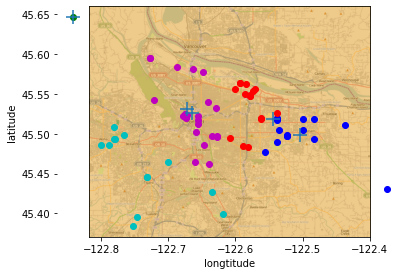

In [82]:
club_clusters('portlandClubs.txt', 'places2.txt', 'clubs_on_map.png', 5)